# Customer Segmentation and Sales Prediction Models for OptiPrice



## Project Overview

This notebook contains the exploration and training of the machine learning algorithms and models used in OptiPrice. K-Means Clustering was opted for customer segmentation due to its simplicity and relevant effectiveness, while XGBoost ultimately provided the best results for sales predictions compared to other regression models (not shown here) such as Random Forest Regressor and Linear Regression. The dataset used in exploring K-Means was also used to train the three XGBoost models.

## Environment Setup and Data Loading

### Importing Libraries

In [ ]:
# Universally required
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from datetime import datetime

# Preprocessing
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, MinMaxScaler

# Clustering
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

# Regression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

# Hyperparameter tuning
!pip install optuna
import optuna


### Data Loading

This dataset was taken from this website: https://data.world/asepetruk/global-superstore

Credit goes to the user **@asepetruk** for uploading and maintaining the dataset.


**Note:** This is ***synthetic*** data, as real-world data of actual supermarkets is incredibly difficult to find given its confidential nature. Even synthetic datasets were not that good, and this was the best one that could be found.

In [ ]:
# Reading the dataset file
datafile = 'Global Data Superstore.xls'
df = pd.read_excel(datafile)

### Initial Data Overview

In [ ]:
df.head()

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,City,State,...,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit,Shipping Cost,Order Priority
0,32298,CA-2012-124891,2012-07-31,2012-07-31,Same Day,RH-19495,Rick Hansen,Consumer,New York City,New York,...,TEC-AC-10003033,Technology,Accessories,Plantronics CS510 - Over-the-Head monaural Wir...,2309.650,7,0.0,762.1845,933.57,Critical
1,26341,IN-2013-77878,2013-02-05,2013-02-07,Second Class,JR-16210,Justin Ritter,Corporate,Wollongong,New South Wales,...,FUR-CH-10003950,Furniture,Chairs,"Novimex Executive Leather Armchair, Black",3709.395,9,0.1,-288.7650,923.63,Critical
2,25330,IN-2013-71249,2013-10-17,2013-10-18,First Class,CR-12730,Craig Reiter,Consumer,Brisbane,Queensland,...,TEC-PH-10004664,Technology,Phones,"Nokia Smart Phone, with Caller ID",5175.171,9,0.1,919.9710,915.49,Medium
3,13524,ES-2013-1579342,2013-01-28,2013-01-30,First Class,KM-16375,Katherine Murray,Home Office,Berlin,Berlin,...,TEC-PH-10004583,Technology,Phones,"Motorola Smart Phone, Cordless",2892.510,5,0.1,-96.5400,910.16,Medium
4,47221,SG-2013-4320,2013-11-05,2013-11-06,Same Day,RH-9495,Rick Hansen,Consumer,Dakar,Dakar,...,TEC-SHA-10000501,Technology,Copiers,"Sharp Wireless Fax, High-Speed",2832.960,8,0.0,311.5200,903.04,Critical


A preview of what the entire dataset looks like is seen here.

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51290 entries, 0 to 51289
Data columns (total 24 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Row ID          51290 non-null  int64         
 1   Order ID        51290 non-null  object        
 2   Order Date      51290 non-null  datetime64[ns]
 3   Ship Date       51290 non-null  datetime64[ns]
 4   Ship Mode       51290 non-null  object        
 5   Customer ID     51290 non-null  object        
 6   Customer Name   51290 non-null  object        
 7   Segment         51290 non-null  object        
 8   City            51290 non-null  object        
 9   State           51290 non-null  object        
 10  Country         51290 non-null  object        
 11  Postal Code     9994 non-null   float64       
 12  Market          51290 non-null  object        
 13  Region          51290 non-null  object        
 14  Product ID      51290 non-null  object        
 15  Ca

This part describes the dataset in general, such as the columns, their datatypes, how many non-null values are in each column, and so on.

In [ ]:
df.shape

(51290, 24)

This essentially means the dataset has 51290 rows and 24 columns.

## Data Preprocessing

### Feature Selection

For the sake of simplicity and quick, workable results given the time and scope constraints of the project, only the following columns are chosen from the selected dataset.

In [ ]:
df = df[['Order Date', 'Customer ID', 'Product ID', 'Quantity', 'Sales']]
df.head()

,Order Date,Customer ID,Product ID,Quantity,Sales
0,2012-07-31,RH-19495,TEC-AC-10003033,7,2309.650
1,2013-02-05,JR-16210,FUR-CH-10003950,9,3709.395
2,2013-10-17,CR-12730,TEC-PH-10004664,9,5175.171
3,2013-01-28,KM-16375,TEC-PH-10004583,5,2892.510
4,2013-11-05,RH-9495,TEC-SHA-10000501,8,2832.960


### Data Cleaning and Transformation

#### Dealing With Missing Values

In [ ]:
df.isnull().sum()  # Finding the number of missing values in each column

,0
Order Date,0
Customer ID,0
Product ID,0
Quantity,0
Sales,0


#### Dealing With Duplicate Values

In [ ]:
df.duplicated().sum()  # Finding the number of duplicated rows

np.int64(9)

In [ ]:
df.drop_duplicates(inplace=True)
df.duplicated().sum()

np.int64(0)

#### Dealing With Inconsistent/Illogical Data

The only columns where negative values were unacceptable were Sales and Quantity, for which such values are not present.

In [ ]:
df[df['Sales'] <= 0]  # Checking if 'Sales' has negative or 0 values

,Order Date,Customer ID,Product ID,Quantity,Sales


In [ ]:
df[df['Quantity'] <= 0]  # Checking if 'Quantity' has negative or 0 values

,Order Date,Customer ID,Product ID,Quantity,Sales


The general information of the dataset is checked once again, followed by checking the number of unique values in the **Product ID** column. Both steps are done to ensure consistency, and the latter serves an additional purpose of providing a preliminary understanding of the approximate sizes of training datasets for each of the three XGBoost models later on.

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 51281 entries, 0 to 51289
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Order Date   51281 non-null  datetime64[ns]
 1   Customer ID  51281 non-null  object        
 2   Product ID   51281 non-null  object        
 3   Quantity     51281 non-null  int64         
 4   Sales        51281 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1), object(2)
memory usage: 2.3+ MB


In [ ]:
df['Product ID'].nunique()  # Number of unique Product IDs

10292

The **Price** column is derived manually here since the original dataset does not have one, and this is the most essential column for price optimization as the process needs to tweak original product prices for maximum sales.

In [ ]:
# Creating a 'Price' column to represent price of each 'Product ID'
df['Price'] = df['Sales'] / df['Quantity']

# Rearranging the column order in the dataframe
df = df[['Customer ID', 'Order Date', 'Product ID', 'Price', 'Quantity', 'Sales']]
df.head()

,Customer ID,Order Date,Product ID,Price,Quantity,Sales
0,RH-19495,2012-07-31,TEC-AC-10003033,329.950,7,2309.650
1,JR-16210,2013-02-05,FUR-CH-10003950,412.155,9,3709.395
2,CR-12730,2013-10-17,TEC-PH-10004664,575.019,9,5175.171
3,KM-16375,2013-01-28,TEC-PH-10004583,578.502,5,2892.510
4,RH-9495,2013-11-05,TEC-SHA-10000501,354.120,8,2832.960


### Customer Segmentation: K-Means Clustering

#### Feature Engineering For Clustering

A copy of the latest version of the dataset is made for this section to ensure separation of concerns, followed by omitting the **Product ID** and **Price** columns. This is done to drive the focus more onto customer-related features.

In [ ]:
clustering_df = df.copy()
clustering_df = clustering_df[['Customer ID', 'Order Date', 'Quantity', 'Sales']]
clustering_df.head()

,Customer ID,Order Date,Quantity,Sales
0,RH-19495,2012-07-31,7,2309.650
1,JR-16210,2013-02-05,9,3709.395
2,CR-12730,2013-10-17,9,5175.171
3,KM-16375,2013-01-28,5,2892.510
4,RH-9495,2013-11-05,8,2832.960


Analysis of the time and scope constraints of the project results in the simple approach of providing the end user of the proposed system with a set of 'measures' on the basis of which they can group customer data. For consistency and an easy-to-follow pattern, said set of features ultimately revolves around **Sales (amount spent), Quantity (Number of items bought), and Number of Visits**. These three features have 4 sets of variations; one being the **totals across the entire dataset**, and the other three being **averages per week, month, and quarter** respectively.

The **Order Date** column is first used to extract **Year-Week, Year-Month, and Year-Quarter** values beforehand, required to engineer the sets of averages later on.

This is followed by engineering the set of totals across the entire dataset. For each set of averages, all columns of the clustering dataset are taken, replacing Order Date with Year-Week, Year-Month, or Year-Quarter (say, timeframe column for short) accordingly. The rows are then grouped per Customer ID per timeframe column to obtain three separate datasets.

These three datasets are then horizontally joined with the set of totals, on the basis of customer ID, forming one big dataset to be used in clustering.

##### Time-Based Feature Derivation

In [ ]:
# Engineering Year-Week, Year-Month, Year-Quarter columns
clustering_df['Year-Week'] = clustering_df['Order Date'].apply(lambda x: f"{x.isocalendar().year}-{x.isocalendar().week}")  # Year-Week
clustering_df['Year-Month'] = clustering_df['Order Date'].apply(lambda x: f"{x.isocalendar().year}-{x.month}")  # Year-Month
clustering_df['Year-Quarter'] = clustering_df['Order Date'].apply(lambda x: f"{x.isocalendar().year}-{(x.month - 1) // 3 + 1}")  # Year-Quarter
clustering_df.head()

,Customer ID,Order Date,Quantity,Sales,Year-Week,Year-Month,Year-Quarter
0,RH-19495,2012-07-31,7,2309.650,2012-31,2012-7,2012-3
1,JR-16210,2013-02-05,9,3709.395,2013-6,2013-2,2013-1
2,CR-12730,2013-10-17,9,5175.171,2013-42,2013-10,2013-4
3,KM-16375,2013-01-28,5,2892.510,2013-5,2013-1,2013-1
4,RH-9495,2013-11-05,8,2832.960,2013-45,2013-11,2013-4


In [ ]:
# Year-Week
clustering_df["Year-Week"] = clustering_df["Order Date"].dt.strftime("%Y-%U")

# Year-Month
clustering_df["Year-Month"] = clustering_df["Order Date"].dt.strftime("%Y-%m")

# Year-Quarter
clustering_df["Year-Quarter"] = clustering_df["Order Date"].dt.to_period("Q")

clustering_df.head()

,Customer ID,Order Date,Quantity,Sales,Year-Week,Year-Month,Year-Quarter
0,RH-19495,2012-07-31,7,2309.650,2012-31,2012-07,2012Q3
1,JR-16210,2013-02-05,9,3709.395,2013-05,2013-02,2013Q1
2,CR-12730,2013-10-17,9,5175.171,2013-41,2013-10,2013Q4
3,KM-16375,2013-01-28,5,2892.510,2013-04,2013-01,2013Q1
4,RH-9495,2013-11-05,8,2832.960,2013-44,2013-11,2013Q4


##### Overall Aggregated Features

In [ ]:
# Engineering totals for Quantity, Sales, and Visits, and Top Product
clustering_df_overall = clustering_df.groupby('Customer ID').agg({
    'Order Date': 'nunique',
    'Sales': 'sum',
    'Quantity': 'sum',
}).reset_index()

clustering_df_overall.rename(columns={
    'Order Date': 'Total Visits',
    'Sales': 'Total Sales',
    'Quantity': 'Total Quantity',
    }, inplace=True)

clustering_df_overall.head()

,Customer ID,Total Visits,Total Sales,Total Quantity
0,AA-10315,19,13747.41300,145
1,AA-10375,23,5884.19500,139
2,AA-10480,20,17695.58978,150
3,AA-10645,35,15343.89070,267
4,AA-315,7,2243.25600,20


##### Weekly Aggregated Features

In [ ]:
# Engineering weekly averages for Quantity, Sales, and Visits
clustering_df_weekly = clustering_df.groupby(['Customer ID', 'Year-Week']).agg({
    'Order Date': 'nunique',
    'Sales': 'sum',
    'Quantity': 'sum'
}).reset_index()

clustering_df_weekly = clustering_df_weekly.groupby('Customer ID').agg({
    'Order Date': 'mean',
    'Sales': 'mean',
    'Quantity': 'mean'
}).reset_index()

clustering_df_weekly.rename(columns={
    'Order Date': 'Average Weekly Visits',
    'Sales': 'Average Weekly Sales',
    'Quantity': 'Average Weekly Quantity',
    }, inplace=True)

clustering_df_weekly.head()

,Customer ID,Average Weekly Visits,Average Weekly Sales,Average Weekly Quantity
0,AA-10315,1.000000,723.548053,7.631579
1,AA-10375,1.000000,255.834565,6.043478
2,AA-10480,1.111111,983.088321,8.333333
3,AA-10645,1.029412,451.290903,7.852941
4,AA-315,1.000000,320.465143,2.857143


##### Monthly Aggregated Features

In [ ]:
# Engineering monthly averages for Quantity, Sales, and Visits
clustering_df_monthly = clustering_df.groupby(['Customer ID', 'Year-Month']).agg({
    'Order Date': 'nunique',
    'Sales': 'sum',
    'Quantity': 'sum'
}).reset_index()

clustering_df_monthly = clustering_df_monthly.groupby('Customer ID').agg({
    'Order Date': 'mean',
    'Sales': 'mean',
    'Quantity': 'mean'
}).reset_index()

clustering_df_monthly.rename(columns={
    'Order Date': 'Average Monthly Visits',
    'Sales': 'Average Monthly Sales',
    'Quantity': 'Average Monthly Quantity',
    }, inplace=True)

clustering_df_monthly.head()

,Customer ID,Average Monthly Visits,Average Monthly Sales,Average Monthly Quantity
0,AA-10315,1.187500,859.213313,9.062500
1,AA-10375,1.210526,309.694474,7.315789
2,AA-10480,1.250000,1105.974361,9.375000
3,AA-10645,1.400000,613.755628,10.680000
4,AA-315,1.166667,373.876000,3.333333


##### Quarterly Aggregated Features

In [ ]:
# Engineering quarterly averages for Quantity, Sales, and Visits
clustering_df_quarterly = clustering_df.groupby(['Customer ID', 'Year-Quarter']).agg({
    'Order Date': 'nunique',
    'Sales': 'sum',
    'Quantity': 'sum'
}).reset_index()

clustering_df_quarterly = clustering_df_quarterly.groupby('Customer ID').agg({
    'Order Date': 'mean',
    'Sales': 'mean',
    'Quantity': 'mean'
}).reset_index()

clustering_df_quarterly.rename(columns={
    'Order Date': 'Average Quarterly Visits',
    'Sales': 'Average Quarterly Sales',
    'Quantity': 'Average Quarterly Quantity',
    }, inplace=True)

clustering_df_quarterly.head()

,Customer ID,Average Quarterly Visits,Average Quarterly Sales,Average Quarterly Quantity
0,AA-10315,1.583333,1145.617750,12.083333
1,AA-10375,1.916667,490.349583,11.583333
2,AA-10480,2.000000,1769.558978,15.000000
3,AA-10645,2.500000,1095.992193,19.071429
4,AA-315,1.400000,448.651200,4.000000


#### Merging Aggregated Customer Data

In [ ]:
clustering_df_overall = clustering_df_overall.merge(clustering_df_weekly, on='Customer ID', how='left')
clustering_df_overall = clustering_df_overall.merge(clustering_df_monthly, on='Customer ID', how='left')
clustering_df_overall = clustering_df_overall.merge(clustering_df_quarterly, on='Customer ID', how='left')

clustering_df_overall.head()

,Customer ID,Total Visits,Total Sales,Total Quantity,Average Weekly Visits,Average Weekly Sales,Average Weekly Quantity,Average Monthly Visits,Average Monthly Sales,Average Monthly Quantity,Average Quarterly Visits,Average Quarterly Sales,Average Quarterly Quantity
0,AA-10315,19,13747.41300,145,1.000000,723.548053,7.631579,1.187500,859.213313,9.062500,1.583333,1145.617750,12.083333
1,AA-10375,23,5884.19500,139,1.000000,255.834565,6.043478,1.210526,309.694474,7.315789,1.916667,490.349583,11.583333
2,AA-10480,20,17695.58978,150,1.111111,983.088321,8.333333,1.250000,1105.974361,9.375000,2.000000,1769.558978,15.000000
3,AA-10645,35,15343.89070,267,1.029412,451.290903,7.852941,1.400000,613.755628,10.680000,2.500000,1095.992193,19.071429
4,AA-315,7,2243.25600,20,1.000000,320.465143,2.857143,1.166667,373.876000,3.333333,1.400000,448.651200,4.000000


#### Data Normalization for Clustering

The big dataset is then normalized using the MinMaxScaler, squishing all numerical values into **ranging from 0 to 1**. This is particularly important considering that ***K-Means works based on Euclidean distances***, meaning that difference in scales of values among columns can **heavily distort the outcome**.

In [ ]:
clustering_df_overall.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1590 entries, 0 to 1589
Data columns (total 13 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Customer ID                 1590 non-null   object 
 1   Total Visits                1590 non-null   int64  
 2   Total Sales                 1590 non-null   float64
 3   Total Quantity              1590 non-null   int64  
 4   Average Weekly Visits       1590 non-null   float64
 5   Average Weekly Sales        1590 non-null   float64
 6   Average Weekly Quantity     1590 non-null   float64
 7   Average Monthly Visits      1590 non-null   float64
 8   Average Monthly Sales       1590 non-null   float64
 9   Average Monthly Quantity    1590 non-null   float64
 10  Average Quarterly Visits    1590 non-null   float64
 11  Average Quarterly Sales     1590 non-null   float64
 12  Average Quarterly Quantity  1590 non-null   float64
dtypes: float64(10), int64(2), object(

In [ ]:
scaler = MinMaxScaler()
numcols = clustering_df_overall.drop(columns=['Customer ID']).columns
clustering_df_overall[numcols] = scaler.fit_transform(clustering_df_overall[numcols])
clustering_df_overall.head()

,Customer ID,Total Visits,Total Sales,Total Quantity,Average Weekly Visits,Average Weekly Sales,Average Weekly Quantity,Average Monthly Visits,Average Monthly Sales,Average Monthly Quantity,Average Quarterly Visits,Average Quarterly Sales,Average Quarterly Quantity
0,AA-10315,0.461538,0.385302,0.362720,0.000000,0.389632,0.255061,0.187500,0.384484,0.310096,0.280,0.329870,0.371697
1,AA-10375,0.564103,0.164803,0.347607,0.000000,0.135246,0.193980,0.210526,0.136513,0.242915,0.440,0.140003,0.354929
2,AA-10480,0.487179,0.496016,0.375315,0.222222,0.530795,0.282051,0.250000,0.495835,0.322115,0.480,0.510660,0.469512
3,AA-10645,0.871795,0.430070,0.670025,0.058824,0.241553,0.263575,0.400000,0.273721,0.372308,0.720,0.315491,0.606054
4,AA-315,0.153846,0.062704,0.047859,0.000000,0.170398,0.071429,0.166667,0.165475,0.089744,0.192,0.127920,0.100610


#### K-Means Model Training and Evaluation

Before actually clustering the data, it is plotted as is beforehand for a quick visual understanding. In either case, 2D plotting is made possible using **PCA** (Principal Component Analysis), reducing the dataset into 2 features.

PCA works on the basis of **eigenvectors and eigenvalues**, which in simple terms are those directions perpendicular to each other in the traditional Cartesian plane along which the data points appear naturally **spread out the most**.

In other words, the x and y axes may not be the best directions to represent the variance in the data, which is why the actual direction in which the **variance is maximum** needs to be considered.

##### Visualizing Data Before Clustering (PCA)

In [ ]:
# Dropping 'Customer ID' before plotting
clustering_X = clustering_df_overall.drop(columns=['Customer ID'])

In [ ]:
# Reducing the dataset into 2 dimensions
pca = PCA(n_components=2)
pca_before_clustering = pca.fit_transform(clustering_X)

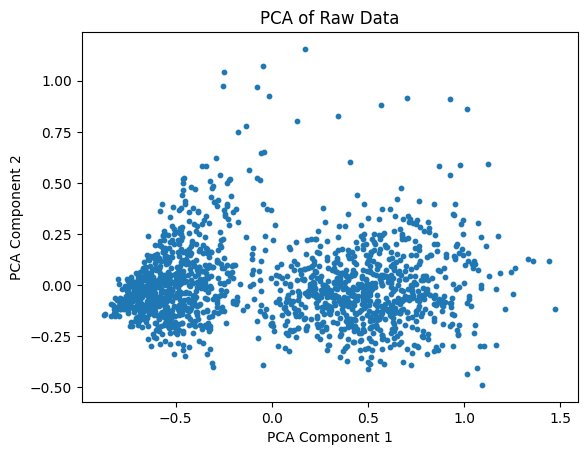

In [ ]:
# Scatter plot of the data before clustering
plt.scatter(pca_before_clustering[:, 0], pca_before_clustering[:, 1], s=10)

plt.title("PCA of Raw Data")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")

plt.show()

##### Determining Optimal Clusters (Silhouette Score)

The Silhouette Score is chosen over the Elbow Method for determining the optimal number of clusters due to its more objective metric for cluster cohesion and separation, reducing possible errors in visual interpretation.

In [ ]:
# Using the Silhouette Score method to find
# the optimal number of clusters
cluster_range = range(2, 11)
silhouette_scores = []

for k in cluster_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(clustering_X)
    labels = kmeans.labels_
    silhouette_avg = silhouette_score(clustering_X, labels)
    silhouette_scores.append(silhouette_avg)

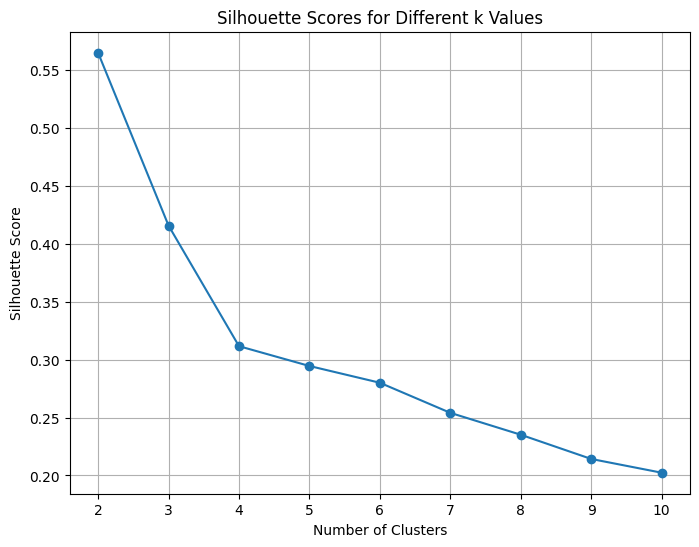

In [ ]:
# Scatter plot of the data before clustering
plt.figure(figsize=(8, 6))

plt.plot(cluster_range, silhouette_scores, marker='o')
plt.title('Silhouette Scores for Different k Values')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')

plt.grid(True)
plt.show()

Based on the Silhouette Score analysis, 2 clusters are identified as optimal for segmenting the customer data. The K-Means model is then trained with this optimal number of clusters.

##### Visualizing Clustered Data (PCA)

In [ ]:
optimal_k = 2  # As seen in the Silhouette Score plot

# Clustering the data and storing the cluster labels
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
clustering_df_overall['Cluster'] = kmeans.fit_predict(clustering_X)

In [ ]:
# Reducing the dataset into 2 dimensions
pca = PCA(n_components=2)
pca_after_clustering = pca.fit_transform(clustering_X)

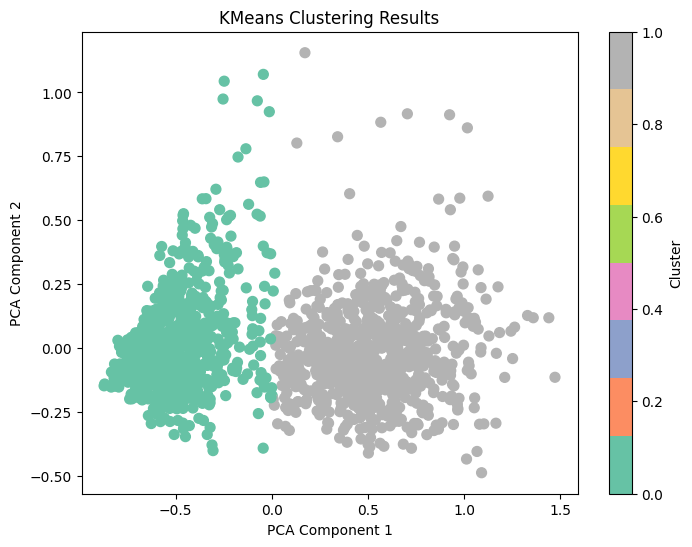

In [ ]:
# Scatter plot of the data after KMeans clustering,
# colors separated by cluster
plt.figure(figsize=(8, 6))
plt.scatter(pca_after_clustering[:, 0], pca_after_clustering[:, 1], c=clustering_df_overall['Cluster'], cmap='Set2', s=50)

plt.title("KMeans Clustering Results")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.colorbar(label='Cluster')

plt.show()

In [ ]:
clustering_df_overall.head()

,Customer ID,Total Visits,Total Sales,Total Quantity,Average Weekly Visits,Average Weekly Sales,Average Weekly Quantity,Average Monthly Visits,Average Monthly Sales,Average Monthly Quantity,Average Quarterly Visits,Average Quarterly Sales,Average Quarterly Quantity,Cluster
0,AA-10315,0.461538,0.385302,0.362720,0.000000,0.389632,0.255061,0.187500,0.384484,0.310096,0.280,0.329870,0.371697,1
1,AA-10375,0.564103,0.164803,0.347607,0.000000,0.135246,0.193980,0.210526,0.136513,0.242915,0.440,0.140003,0.354929,1
2,AA-10480,0.487179,0.496016,0.375315,0.222222,0.530795,0.282051,0.250000,0.495835,0.322115,0.480,0.510660,0.469512,1
3,AA-10645,0.871795,0.430070,0.670025,0.058824,0.241553,0.263575,0.400000,0.273721,0.372308,0.720,0.315491,0.606054,1
4,AA-315,0.153846,0.062704,0.047859,0.000000,0.170398,0.071429,0.166667,0.165475,0.089744,0.192,0.127920,0.100610,0


### Sales Prediction: XGBoost Regressor

**XGBoost** was one of the top considerations for this section, since it is an embedded model, meaning it tends to have an advantage over standalone models such as linear regression.

It also tends to have an edge over other embedded algorithms, such as Random Forest. This is because while both XGBoost and Random Forest use the same standalone model as their base, i.e., the **Decision Tree**, XGBoost uses **boosting** while Random Forest uses **bagging**.

In a broad sense, this essentially means that XGBoost actually ***iteratively reduces the loss of each preceding Decision Tree model***, while Random Forest simply trains several Decision Trees and considers the one with the best performance as the final model.

Like all regression models, the performance of XGBoost models is evaluated based on metrics like MAE (Mean Absolute Error), MSE (Mean Squared Error), and R2 Score.

For sales prediction, the original dataset is again copied to maintain separation of concerns, and **Customer ID is omitted** to drive the focus more towards product data.

In [ ]:
prediction_df = df.copy()
prediction_df = prediction_df[['Product ID', 'Order Date', 'Price', 'Quantity', 'Sales']]
prediction_df.head()

,Product ID,Order Date,Price,Quantity,Sales
0,TEC-AC-10003033,2012-07-31,329.950,7,2309.650
1,FUR-CH-10003950,2013-02-05,412.155,9,3709.395
2,TEC-PH-10004664,2013-10-17,575.019,9,5175.171
3,TEC-PH-10004583,2013-01-28,578.502,5,2892.510
4,TEC-SHA-10000501,2013-11-05,354.120,8,2832.960


#### Feature Engineering for Sales Prediction

This follows a similar approach to what was done for clustering, where **Year-Week, Year-Month, and Year-Quarter** are calculated first. However, this time the prediction dataset has all the features mentioned above, **with the addition of the 3 timeframe columns**.

To train a model for predicting sales for one timeframe, the remaining timeframe columns are omitted prior to actual feature engineering. For e.g., for training the weekly model, **Year-Month and Year-Quarter** would be eliminated.

For each model, a variety of features are engineered and iteratively tested and evaluated. The **target** column is **Sales Next Week/Month/Quarter** accordingly.

Essentially, the features that have been ultimately used are the result of two rounds of engineering. As in, the 'base' columns of each model's training dataset are used to create features such as Sales Last Week, Sales This Week, Sales Next Week (and similar for Quantity and Price, for each timeframe). These are then used again to engineer features such as Rolling Average Sales, Price to Stock Ratio, etc. This is done to ensure that the impact of each base column is captured from different angles as best as possible.

The decision to choose the features that have been chosen as the final ones is made by analyzing the feature importance of each feature tested during each round of training each model.

Some of the tested features are still present as commented code.

Additionally, the best set of hyperparameters for each model is also determined, by using **Optuna**. It is provided with a range of values for each hyperparameter such as the maximum depth of trees, learning rate, etc. to test the model's loss function in each iteration.

##### Timeframe Derivation

In [ ]:
prediction_df['Year-Week'] = prediction_df['Order Date'].apply(lambda x: f"{x.isocalendar().year}-{x.isocalendar().week}")  # Year-Week
prediction_df['Year-Month'] = prediction_df['Order Date'].apply(lambda x: f"{x.isocalendar().year}-{x.month}")  # Year-Month
prediction_df['Year-Quarter'] = prediction_df['Order Date'].apply(lambda x: f"{x.isocalendar().year}-{(x.month - 1) // 3 + 1}")  # Year-Quarter
prediction_df.head()

,Product ID,Order Date,Price,Quantity,Sales,Year-Week,Year-Month,Year-Quarter
0,TEC-AC-10003033,2012-07-31,329.950,7,2309.650,2012-31,2012-7,2012-3
1,FUR-CH-10003950,2013-02-05,412.155,9,3709.395,2013-6,2013-2,2013-1
2,TEC-PH-10004664,2013-10-17,575.019,9,5175.171,2013-42,2013-10,2013-4
3,TEC-PH-10004583,2013-01-28,578.502,5,2892.510,2013-5,2013-1,2013-1
4,TEC-SHA-10000501,2013-11-05,354.120,8,2832.960,2013-45,2013-11,2013-4


##### Weekly Sales Prediction Model

This section focuses on preparing the data and training the XGBoost model specifically for weekly sales predictions. Features are engineered to capture weekly trends, lags, and ratios, designed to provide comprehensive input for the model.

###### Data Aggregation and Lag Feature Engineering

In [ ]:
prediction_df_weekly = prediction_df.copy().drop(columns=['Year-Month', 'Year-Quarter'])
prediction_df_weekly

,Product ID,Order Date,Price,Quantity,Sales,Year-Week
0,TEC-AC-10003033,2012-07-31,329.950,7,2309.650,2012-31
1,FUR-CH-10003950,2013-02-05,412.155,9,3709.395,2013-6
2,TEC-PH-10004664,2013-10-17,575.019,9,5175.171,2013-42
3,TEC-PH-10004583,2013-01-28,578.502,5,2892.510,2013-5
4,TEC-SHA-10000501,2013-11-05,354.120,8,2832.960,2013-45
...,...,...,...,...,...,...
51285,OFF-FA-10000746,2014-06-19,13.020,5,65.100,2014-25
51286,OFF-AP-10002906,2014-06-20,0.444,1,0.444,2014-25
51287,OFF-EN-10001219,2013-12-02,7.640,3,22.920,2013-49
51288,OFF-BI-10000806,2012-02-18,6.720,2,13.440,2012-7


In [ ]:
prediction_df_weekly = prediction_df_weekly.groupby(['Product ID', 'Year-Week']).agg({
    'Price': 'mean',
    'Quantity': 'sum',
    'Sales': 'sum'
}).reset_index()

prediction_df_weekly

,Product ID,Year-Week,Price,Quantity,Sales
0,FUR-ADV-10000002,2014-19,53.040,2,106.080
1,FUR-ADV-10000002,2014-37,53.040,1,53.040
2,FUR-ADV-10000108,2011-15,50.010,2,100.020
3,FUR-ADV-10000108,2012-19,50.010,1,50.010
4,FUR-ADV-10000108,2012-8,50.010,4,200.040
...,...,...,...,...,...
50327,TEC-STA-10004542,2014-28,28.056,15,577.152
50328,TEC-STA-10004542,2014-52,40.080,4,160.320
50329,TEC-STA-10004834,2011-44,43.092,4,172.368
50330,TEC-STA-10004834,2013-35,32.319,1,32.319


In [ ]:
prediction_df_weekly = prediction_df_weekly.sort_values(by=['Product ID', 'Year-Week'])

# Quantity last week
prediction_df_weekly['Quantity Last Week'] = prediction_df_weekly.groupby('Product ID')['Quantity'].shift(1)
prediction_df_weekly = prediction_df_weekly.dropna(subset=['Quantity Last Week'])

# Sales last week and next week
prediction_df_weekly['Sales Last Week'] = prediction_df_weekly.groupby('Product ID')['Sales'].shift(1)
prediction_df_weekly = prediction_df_weekly.dropna(subset=['Sales Last Week'])

prediction_df_weekly['Sales Next Week'] = prediction_df_weekly.groupby('Product ID')['Sales'].shift(-1)
prediction_df_weekly = prediction_df_weekly.dropna(subset=['Sales Next Week'])

prediction_df_weekly = prediction_df_weekly.reset_index(drop=True)

# Rearranging columns
prediction_df_weekly = prediction_df_weekly[['Product ID', 'Year-Week', 'Price', 'Quantity Last Week', 'Sales Last Week', 'Quantity', 'Sales', 'Sales Next Week']]

# Renaming columns
prediction_df_weekly.rename(columns={
    'Price': 'Price This Week',
    'Sales': 'Sales This Week',
    'Quantity': 'Quantity This Week'
  }, inplace=True)

<ipython-input-124-115bf004b934>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prediction_df_weekly['Sales Next Week'] = prediction_df_weekly.groupby('Product ID')['Sales'].shift(-1)


In [ ]:
# Price last week
prediction_df_weekly["Price Last Week"] = prediction_df_weekly.groupby("Product ID")["Price This Week"].shift(1)
prediction_df_weekly = prediction_df_weekly.dropna(subset=['Price Last Week'])

# Price change % (change from price last week to price this week, per unit price last week)
prediction_df_weekly["Price Change (%)"] = (prediction_df_weekly["Price This Week"] - prediction_df_weekly["Price Last Week"]) / prediction_df_weekly["Price Last Week"]
prediction_df_weekly = prediction_df_weekly.dropna(subset=['Price Change (%)'])

# Sales growth rate (growth from sales last week to sales this Week, per unit sales last Week)
prediction_df_weekly["Sales Growth Rate"] = (prediction_df_weekly["Sales This Week"] - prediction_df_weekly["Sales Last Week"]) / prediction_df_weekly["Sales Last Week"]
prediction_df_weekly = prediction_df_weekly.dropna(subset=['Sales Growth Rate'])

# Stock to sales ratio (ratio of quantity this week to sales this week)
prediction_df_weekly["Stock to Sales Ratio"] = prediction_df_weekly["Quantity This Week"] / (prediction_df_weekly["Sales This Week"] + 1)
prediction_df_weekly = prediction_df_weekly.dropna(subset=['Stock to Sales Ratio'])

# Momentum (sales this week - sales last week)
prediction_df_weekly["Momentum"] = prediction_df_weekly["Sales This Week"] - prediction_df_weekly["Sales Last Week"]
prediction_df_weekly = prediction_df_weekly.dropna(subset=['Momentum'])

# Rolling average sales (mean of sales this week and sales last week)
prediction_df_weekly["Rolling Average Sales"] = prediction_df_weekly[["Sales Last Week", "Sales This Week"]].mean(axis=1)
prediction_df_weekly = prediction_df_weekly.dropna(subset=['Rolling Average Sales'])

# Price to Sales Ratio
prediction_df_weekly["Price-to-Sales Ratio"] = prediction_df_weekly["Price This Week"] / (prediction_df_weekly["Sales This Week"] + 1)
prediction_df_weekly = prediction_df_weekly.dropna(subset=['Price-to-Sales Ratio'])


# # Elasticity ratios
# # First calculating the change % of quantity and sales
# prediction_df_weekly["Quantity Change (%)"] = (prediction_df_weekly["Quantity This Week"] - prediction_df_weekly["Quantity Last Week"]) / prediction_df_weekly["Quantity Last Week"]
# prediction_df_weekly = prediction_df_weekly.dropna(subset=['Quantity Change (%)'])
# prediction_df_weekly["Sales Change (%)"] = (prediction_df_weekly["Sales This Week"] - prediction_df_weekly["Sales Last Week"]) / prediction_df_weekly["Sales Last Week"]
# prediction_df_weekly = prediction_df_weekly.dropna(subset=['Sales Change (%)'])

# # Price-Quantity elasticity
# prediction_df_weekly["Price-Quantity Elasticity"] = prediction_df_weekly["Quantity Change (%)"] / (prediction_df_weekly["Price Change (%)"] + 1)
# prediction_df_weekly = prediction_df_weekly.dropna(subset=['Price-Quantity Elasticity'])

# # Price-Sales elasticity
# prediction_df_weekly["Price-Sales Elasticity"] = prediction_df_weekly["Sales Change (%)"] / (prediction_df_weekly["Price Change (%)"] + 1)
# prediction_df_weekly = prediction_df_weekly.dropna(subset=['Price-Sales Elasticity'])

# # Price Impact
# prediction_df_weekly["Price-Impact"] = (prediction_df_weekly["Price-Sales Elasticity"] + prediction_df_weekly["Price-Quantity Elasticity"]) / 2
# prediction_df_weekly = prediction_df_weekly.dropna(subset=['Price-Impact'])

prediction_df_weekly = prediction_df_weekly.reset_index(drop=True)

prediction_df_weekly

,Product ID,Year-Week,Price This Week,Quantity Last Week,Sales Last Week,Quantity This Week,Sales This Week,Sales Next Week,Price Last Week,Price Change (%),Sales Growth Rate,Stock to Sales Ratio,Momentum,Rolling Average Sales,Price-to-Sales Ratio
0,FUR-ADV-10000183,2013-2,15.894,2.0,105.960,6,95.364,84.768,52.980,-0.700000,-0.100000,0.062264,-10.596,100.662,0.164937
1,FUR-ADV-10000183,2014-33,21.192,6.0,95.364,4,84.768,52.980,15.894,0.333333,-0.111111,0.046637,-10.596,90.066,0.247085
2,FUR-ADV-10000183,2014-34,52.980,4.0,84.768,1,52.980,52.980,21.192,1.500000,-0.375000,0.018525,-31.788,68.874,0.981475
3,FUR-ADV-10000183,2014-4,52.980,1.0,52.980,1,52.980,317.880,52.980,0.000000,0.000000,0.018525,0.000,52.980,0.981475
4,FUR-ADV-10000188,2014-2,24.990,1.0,9.996,1,24.990,24.990,9.996,1.500000,1.500000,0.038476,14.994,17.493,0.961524
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17250,TEC-STA-10003550,2014-2,160.650,4.0,642.600,1,160.650,321.300,160.650,0.000000,-0.750000,0.006186,-481.950,401.625,0.993814
17251,TEC-STA-10003550,2014-34,160.650,1.0,160.650,2,321.300,321.300,160.650,0.000000,1.000000,0.006205,160.650,240.975,0.498449
17252,TEC-STA-10004181,2014-43,300.180,1.0,120.072,1,300.180,600.360,120.072,1.500000,1.500000,0.003320,180.108,210.126,0.996680
17253,TEC-STA-10004181,2014-45,300.180,1.0,300.180,2,600.360,1200.720,300.180,0.000000,1.000000,0.003326,300.180,450.270,0.499169


In [ ]:
prediction_df_weekly['Product ID'].nunique()

4924

In [ ]:
prediction_df_weekly.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17255 entries, 0 to 17254
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Product ID             17255 non-null  object 
 1   Year-Week              17255 non-null  object 
 2   Price This Week        17255 non-null  float64
 3   Quantity Last Week     17255 non-null  float64
 4   Sales Last Week        17255 non-null  float64
 5   Quantity This Week     17255 non-null  int64  
 6   Sales This Week        17255 non-null  float64
 7   Sales Next Week        17255 non-null  float64
 8   Price Last Week        17255 non-null  float64
 9   Price Change (%)       17255 non-null  float64
 10  Sales Growth Rate      17255 non-null  float64
 11  Stock to Sales Ratio   17255 non-null  float64
 12  Momentum               17255 non-null  float64
 13  Rolling Average Sales  17255 non-null  float64
 14  Price-to-Sales Ratio   17255 non-null  float64
dtypes:

###### Exploratory Data Analysis (EDA)

Prior to model training, an Exploratory Data Analysis (EDA) is performed on the prepared weekly dataset. This involves visualizing feature relationships through pair plots and quantifying correlations using a heatmap to understand the dataset's structure and identify potential relationships between features and the target variable.

In [ ]:
# Dropping weakly-related features
cols_to_keep_weekly = [
    'Price This Week',
    # 'Price Last Week',
    # 'Sales This Week',
    # 'Sales Last Week',
    # 'Quantity This Week',
    # 'Quantity Last Week',
    'Price Change (%)',
    # 'Sales Growth Rate',
    'Stock to Sales Ratio',
    # 'Momentum',
    'Rolling Average Sales',
    # 'Price-to-Sales Ratio',
    # "Price-Quantity Elasticity",
    # "Price-Sales Elasticity",
    # "Price-Impact",
    'Sales Next Week'
  ]

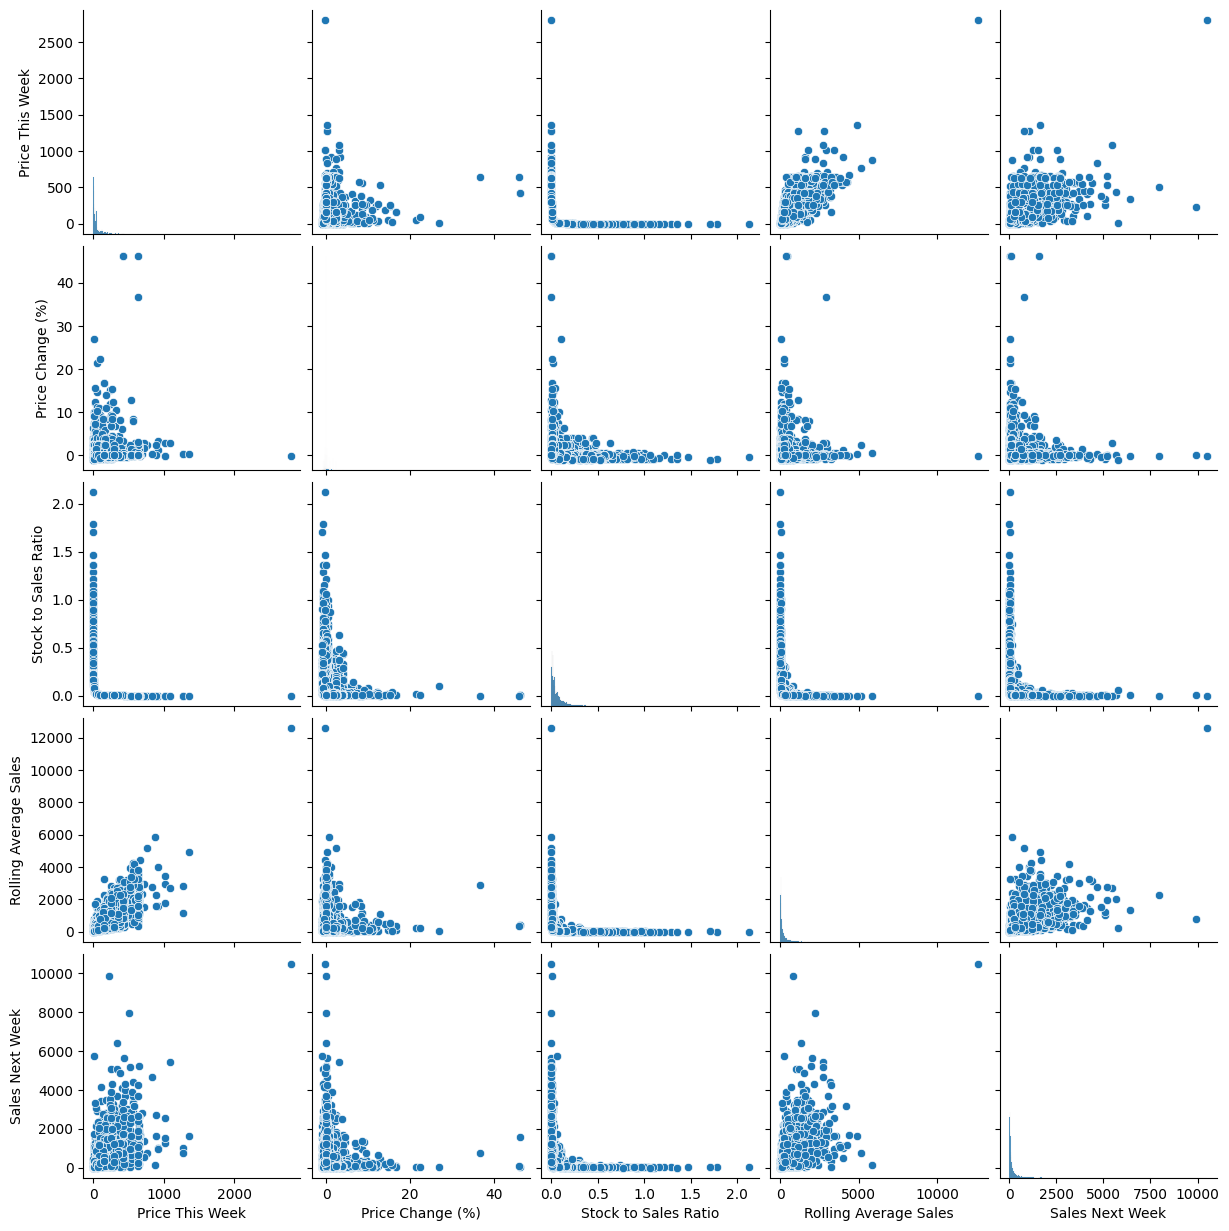

In [ ]:
# Scatter plot
sns.pairplot(prediction_df_weekly[cols_to_keep_weekly])

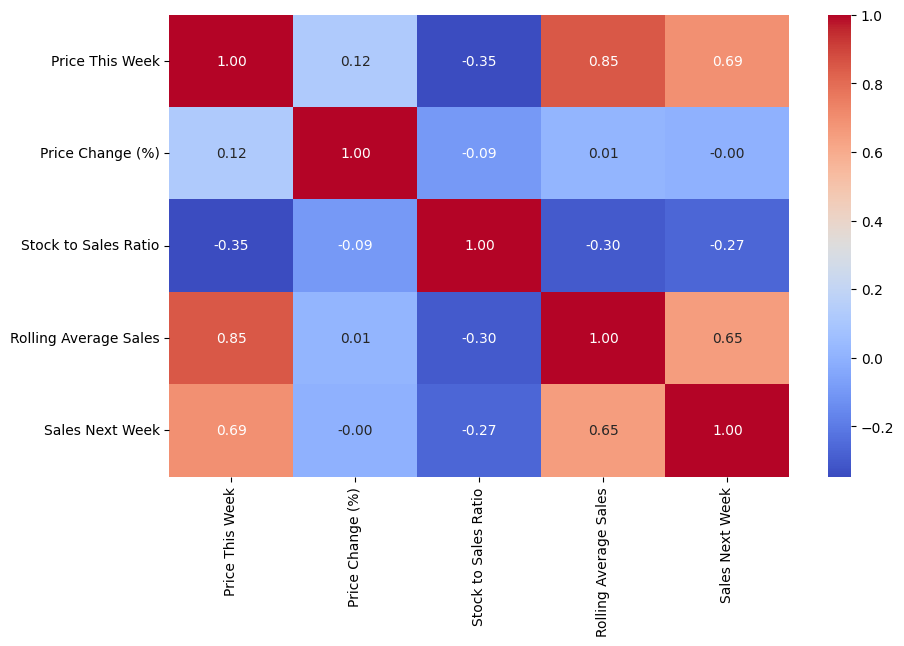

In [ ]:
# Correlation Heatmap
plt.figure(figsize=(10,6))
sns.heatmap(prediction_df_weekly[cols_to_keep_weekly].corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.show()

###### Model Training and Evaluation

In [ ]:
weekly_X = prediction_df_weekly[cols_to_keep_weekly].drop(columns={'Sales Next Week'})
weekly_y = prediction_df_weekly['Sales Next Week']
# prediction_df_weekly['log_sales'] = np.log1p(prediction_df_weekly['Sales Next Week'])
# weekly_y = prediction_df_weekly['log_sales']

In [ ]:
weekly_X

,Price This Week,Price Change (%),Stock to Sales Ratio,Rolling Average Sales
0,15.894,-0.700000,0.062264,100.662
1,21.192,0.333333,0.046637,90.066
2,52.980,1.500000,0.018525,68.874
3,52.980,0.000000,0.018525,52.980
4,24.990,1.500000,0.038476,17.493
...,...,...,...,...
17250,160.650,0.000000,0.006186,401.625
17251,160.650,0.000000,0.006205,240.975
17252,300.180,1.500000,0.003320,210.126
17253,300.180,0.000000,0.003326,450.270


In [ ]:
weekly_y

,Sales Next Week
0,84.768
1,52.980
2,52.980
3,317.880
4,24.990
...,...
17250,321.300
17251,321.300
17252,600.360
17253,1200.720


**Data Splitting:** The dataset is divided into training, validation, and test sets to ensure robust model evaluation and hyperparameter tuning.

In [ ]:
weekly_X_train, weekly_X_temp, weekly_y_train, weekly_y_temp = train_test_split(weekly_X, weekly_y, test_size=0.2, random_state=42)

weekly_X_val, weekly_X_test, weekly_y_val, weekly_y_test = train_test_split(weekly_X_temp, weekly_y_temp, test_size=0.5, random_state=42)


**Hyperparameter Optimization and Model Training:** Optuna is utilized to find the optimal hyperparameters for the XGBoost Regressor.

In [ ]:
# Define an objective function for Optuna
def objective(trial, X_train, y_train, X_val, y_val):
    # Suggest values for the hyperparameters
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
    max_depth = trial.suggest_int('max_depth', 3, 10)
    n_estimators = trial.suggest_int('n_estimators', 100, 1000)

    # Train XGBoost model with the suggested hyperparameters
    model = XGBRegressor(
        learning_rate=learning_rate,
        max_depth=max_depth,
        n_estimators=n_estimators,
        random_state=42
    )

    # Train the model
    model.fit(X_train, y_train)

    # Predict and evaluate
    y_pred = model.predict(X_val)
    r2 = r2_score(y_val, y_pred)

    return r2  # Objective function to minimize (lower MSE is better)


In [ ]:
# Create an Optuna study
study = optuna.create_study(direction='maximize')

# Optimize the objective function
study.optimize(lambda trial: objective(trial, weekly_X_train, weekly_y_train, weekly_X_val, weekly_y_val), n_trials=50)

# Print the best hyperparameters and performance
print(f"Best hyperparameters: {study.best_params}")
print(f"Best MSE: {study.best_value}")


[I 2025-04-09 15:59:52,896] A new study created in memory with name: no-name-ebce7b68-b87e-4d3d-810c-779dfe913c84
<ipython-input-135-caa56a9480ba>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
[I 2025-04-09 15:59:54,345] Trial 0 finished with value: 0.5581867994649079 and parameters: {'learning_rate': 0.006048150592017239, 'max_depth': 3, 'n_estimators': 874}. Best is trial 0 with value: 0.5581867994649079.
<ipython-input-135-caa56a9480ba>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
[I 2025-04-09 15:59:56,079] Trial 1 finish

Best hyperparameters: {'learning_rate': 0.0038010346658293873, 'max_depth': 5, 'n_estimators': 925}
Best MSE: 0.5745780994493044


In [ ]:
import xgboost

<Figure size 1200x800 with 0 Axes>

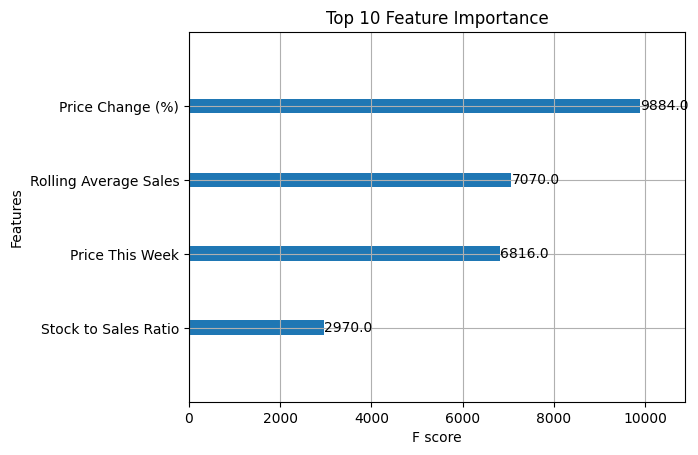

MAE: 110.70
MSE: 53610.53
R² Score: 0.57


In [ ]:
# Use the best hyperparameters from Optuna
hyperparams = study.best_params

xgb_weekly = XGBRegressor(
    n_estimators=hyperparams['n_estimators'],
    learning_rate=hyperparams['learning_rate'],
    max_depth=hyperparams['max_depth'],
    random_state=42
)

# Train the final model
xgb_weekly.fit(weekly_X_train, weekly_y_train)

importance = xgb_weekly.get_booster().get_score(importance_type='weight')

# Visualize the feature importance
plt.figure(figsize=(12, 8))
xgboost.plot_importance(xgb_weekly, importance_type='weight', max_num_features=10)
plt.title('Top 10 Feature Importance')
plt.show()

# Predict and evaluate on the validation set
weekly_y_pred = xgb_weekly.predict(weekly_X_val)


# Calculate metrics
mae = mean_absolute_error(weekly_y_val, weekly_y_pred)
mse = mean_squared_error(weekly_y_val, weekly_y_pred)
r2 = r2_score(weekly_y_val, weekly_y_pred)



# # Predict and evaluate on the validation set
# weekly_y_pred_log = xgb_weekly.predict(weekly_X_val)
# weekly_y_pred_unlog = np.expm1(weekly_y_pred_log)  # Convert log-predictions back to original scale

# weekly_y_val_unlog = np.expm1(weekly_y_val)  # Un-log transform actual values

# # Calculate metrics
# mae = mean_absolute_error(weekly_y_val_unlog, weekly_y_pred_unlog)
# mse = mean_squared_error(weekly_y_val_unlog, weekly_y_pred_unlog)
# r2 = r2_score(weekly_y_val_unlog, weekly_y_pred_unlog)

# Print performance metrics
print(f"MAE: {mae:.2f}")
print(f"MSE: {mse:.2f}")
print(f"R² Score: {r2:.2f}")


In [ ]:
weekly_y_pred.shape

(1725,)

##### Monthly Sales Prediction Model

This section focuses on preparing the data and training the XGBoost model specifically for monthly sales predictions. Features are engineered to capture monthly trends, lags, and ratios, designed to provide comprehensive input for the model.

###### Data Aggregation and Lag Feature Engineering

In [ ]:
prediction_df_monthly = prediction_df.copy().drop(columns=['Year-Week', 'Year-Quarter'])
prediction_df_monthly

,Product ID,Order Date,Price,Quantity,Sales,Year-Month
0,TEC-AC-10003033,2012-07-31,329.950,7,2309.650,2012-7
1,FUR-CH-10003950,2013-02-05,412.155,9,3709.395,2013-2
2,TEC-PH-10004664,2013-10-17,575.019,9,5175.171,2013-10
3,TEC-PH-10004583,2013-01-28,578.502,5,2892.510,2013-1
4,TEC-SHA-10000501,2013-11-05,354.120,8,2832.960,2013-11
...,...,...,...,...,...,...
51285,OFF-FA-10000746,2014-06-19,13.020,5,65.100,2014-6
51286,OFF-AP-10002906,2014-06-20,0.444,1,0.444,2014-6
51287,OFF-EN-10001219,2013-12-02,7.640,3,22.920,2013-12
51288,OFF-BI-10000806,2012-02-18,6.720,2,13.440,2012-2


In [ ]:
prediction_df_monthly = prediction_df_monthly.groupby(['Product ID', 'Year-Month']).agg({
    'Price': 'mean',
    'Quantity': 'sum',
    'Sales': 'sum'
}).reset_index()

prediction_df_monthly

,Product ID,Year-Month,Price,Quantity,Sales
0,FUR-ADV-10000002,2014-5,53.040,2,106.080
1,FUR-ADV-10000002,2014-9,53.040,1,53.040
2,FUR-ADV-10000108,2011-4,50.010,2,100.020
3,FUR-ADV-10000108,2012-2,50.010,4,200.040
4,FUR-ADV-10000108,2012-5,50.010,1,50.010
...,...,...,...,...,...
47395,TEC-STA-10004542,2014-12,40.080,4,160.320
47396,TEC-STA-10004542,2014-7,28.056,15,577.152
47397,TEC-STA-10004834,2011-11,43.092,4,172.368
47398,TEC-STA-10004834,2013-8,32.319,1,32.319


In [ ]:
prediction_df_monthly = prediction_df_monthly.sort_values(by=['Product ID', 'Year-Month'])

# Quantity last month
prediction_df_monthly['Quantity Last Month'] = prediction_df_monthly.groupby('Product ID')['Quantity'].shift(1)
prediction_df_monthly = prediction_df_monthly.dropna(subset=['Quantity Last Month'])

# Sales last month and next month
prediction_df_monthly['Sales Last Month'] = prediction_df_monthly.groupby('Product ID')['Sales'].shift(1)
prediction_df_monthly = prediction_df_monthly.dropna(subset=['Sales Last Month'])

prediction_df_monthly['Sales Next Month'] = prediction_df_monthly.groupby('Product ID')['Sales'].shift(-1)
prediction_df_monthly = prediction_df_monthly.dropna(subset=['Sales Next Month'])

prediction_df_monthly = prediction_df_monthly.reset_index(drop=True)

# Rearranging columns
prediction_df_monthly = prediction_df_monthly[['Product ID', 'Year-Month', 'Price', 'Quantity Last Month', 'Sales Last Month', 'Quantity', 'Sales', 'Sales Next Month']]

# Renaming columns
prediction_df_monthly.rename(columns={
    'Price': 'Price This Month',
    'Sales': 'Sales This Month',
    'Quantity': 'Quantity This Month'
  }, inplace=True)

In [ ]:
# Price last month
prediction_df_monthly["Price Last Month"] = prediction_df_monthly.groupby("Product ID")["Price This Month"].shift(1)
prediction_df_monthly = prediction_df_monthly.dropna(subset=['Price Last Month'])

# Price change % (change from price last month to price this month, per unit price last month)
prediction_df_monthly["Price Change (%)"] = (prediction_df_monthly["Price This Month"] - prediction_df_monthly["Price Last Month"]) / prediction_df_monthly["Price Last Month"]
prediction_df_monthly = prediction_df_monthly.dropna(subset=['Price Change (%)'])

# Sales growth rate (growth from sales last month to sales this month, per unit sales last month)
prediction_df_monthly["Sales Growth Rate"] = (prediction_df_monthly["Sales This Month"] - prediction_df_monthly["Sales Last Month"]) / prediction_df_monthly["Sales Last Month"]
prediction_df_monthly = prediction_df_monthly.dropna(subset=['Sales Growth Rate'])

# Stock to sales ratio (ratio of quantity this month to sales this month)
prediction_df_monthly["Stock to Sales Ratio"] = prediction_df_monthly["Quantity This Month"] / (prediction_df_monthly["Sales This Month"] + 1)
prediction_df_monthly = prediction_df_monthly.dropna(subset=['Stock to Sales Ratio'])

# Momentum (sales this month - sales last month)
prediction_df_monthly["Momentum"] = prediction_df_monthly["Sales This Month"] - prediction_df_monthly["Sales Last Month"]
prediction_df_monthly = prediction_df_monthly.dropna(subset=['Momentum'])

# Rolling average sales (mean of sales this month and sales last month)
prediction_df_monthly["Rolling Average Sales"] = prediction_df_monthly[["Sales Last Month", "Sales This Month"]].mean(axis=1)
prediction_df_monthly = prediction_df_monthly.dropna(subset=['Rolling Average Sales'])

# Price to Sales Ratio
prediction_df_monthly["Price-to-Sales Ratio"] = prediction_df_monthly["Price This Month"] / (prediction_df_monthly["Sales This Month"] + 1)
prediction_df_monthly = prediction_df_monthly.dropna(subset=['Price-to-Sales Ratio'])



# # Elasticity ratios
# # First calculating the change % of quantity and sales
# prediction_df_monthly["Quantity Change (%)"] = (prediction_df_monthly["Quantity This Month"] - prediction_df_monthly["Quantity Last Month"]) / prediction_df_monthly["Quantity Last Month"]
# prediction_df_monthly = prediction_df_monthly.dropna(subset=['Quantity Change (%)'])
# prediction_df_monthly["Sales Change (%)"] = (prediction_df_monthly["Sales This Month"] - prediction_df_monthly["Sales Last Month"]) / prediction_df_monthly["Sales Last Month"]
# prediction_df_monthly = prediction_df_monthly.dropna(subset=['Sales Change (%)'])

# # Price-Quantity elasticity
# prediction_df_monthly["Price-Quantity Elasticity"] = prediction_df_monthly["Quantity Change (%)"] / (prediction_df_monthly["Price Change (%)"] + 1)
# prediction_df_monthly = prediction_df_monthly.dropna(subset=['Price-Quantity Elasticity'])

# # Price-Sales elasticity
# prediction_df_monthly["Price-Sales Elasticity"] = prediction_df_monthly["Sales Change (%)"] / (prediction_df_monthly["Price Change (%)"] + 1)
# prediction_df_monthly = prediction_df_monthly.dropna(subset=['Price-Sales Elasticity'])

# # Price Impact
# prediction_df_monthly["Price-Impact"] = (prediction_df_monthly["Price-Sales Elasticity"] + prediction_df_monthly["Price-Quantity Elasticity"]) / 2
# prediction_df_monthly = prediction_df_monthly.dropna(subset=['Price-Impact'])

prediction_df_monthly = prediction_df_monthly.reset_index(drop=True)

prediction_df_monthly

,Product ID,Year-Month,Price This Month,Quantity Last Month,Sales Last Month,Quantity This Month,Sales This Month,Sales Next Month,Price Last Month,Price Change (%),Sales Growth Rate,Stock to Sales Ratio,Momentum,Rolling Average Sales,Price-to-Sales Ratio
0,FUR-ADV-10000183,2013-1,15.894,2.0,105.960,6,95.364,52.980,52.980,-7.000000e-01,-0.100000,0.062264,-10.596,100.662,0.164937
1,FUR-ADV-10000183,2014-1,52.980,6.0,95.364,1,52.980,317.880,15.894,2.333333e+00,-0.444444,0.018525,-42.384,74.172,0.981475
2,FUR-ADV-10000183,2014-12,52.980,1.0,52.980,6,317.880,137.748,52.980,-1.341153e-16,5.000000,0.018816,264.900,185.430,0.166144
3,FUR-ADV-10000188,2014-1,24.990,1.0,9.996,1,24.990,24.990,9.996,1.500000e+00,1.500000,0.038476,14.994,17.493,0.961524
4,FUR-ADV-10000571,2013-10,109.740,1.0,109.740,1,109.740,219.480,109.740,0.000000e+00,0.000000,0.009030,0.000,109.740,0.990970
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14597,TEC-STA-10003330,2013-9,253.320,1.0,101.328,3,759.960,253.320,101.328,1.500000e+00,6.500000,0.003942,658.632,430.644,0.332895
14598,TEC-STA-10003550,2014-4,160.650,2.0,321.300,4,642.600,642.600,160.650,0.000000e+00,1.000000,0.006215,321.300,481.950,0.249612
14599,TEC-STA-10003550,2014-5,160.650,4.0,642.600,4,642.600,321.300,160.650,0.000000e+00,0.000000,0.006215,0.000,642.600,0.249612
14600,TEC-STA-10004181,2014-10,300.180,1.0,120.072,1,300.180,600.360,120.072,1.500000e+00,1.500000,0.003320,180.108,210.126,0.996680


In [ ]:
prediction_df_monthly.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14602 entries, 0 to 14601
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Product ID             14602 non-null  object 
 1   Year-Month             14602 non-null  object 
 2   Price This Month       14602 non-null  float64
 3   Quantity Last Month    14602 non-null  float64
 4   Sales Last Month       14602 non-null  float64
 5   Quantity This Month    14602 non-null  int64  
 6   Sales This Month       14602 non-null  float64
 7   Sales Next Month       14602 non-null  float64
 8   Price Last Month       14602 non-null  float64
 9   Price Change (%)       14602 non-null  float64
 10  Sales Growth Rate      14602 non-null  float64
 11  Stock to Sales Ratio   14602 non-null  float64
 12  Momentum               14602 non-null  float64
 13  Rolling Average Sales  14602 non-null  float64
 14  Price-to-Sales Ratio   14602 non-null  float64
dtypes:

###### Exploratory Data Analysis (EDA)

Prior to model training, an Exploratory Data Analysis (EDA) is performed on the prepared monthly dataset. This involves visualizing feature relationships through pair plots and quantifying correlations using a heatmap to understand the dataset's structure and identify potential relationships between features and the target variable.

In [ ]:
# Dropping weakly-related features
cols_to_keep_monthly = [
    'Price This Month',
    # 'Price Last Month',
    # 'Sales This Month',
    # 'Sales Last Month',
    # 'Quantity This Month',
    # 'Quantity Last Month',
    'Price Change (%)',
    # 'Sales Growth Rate',
    'Stock to Sales Ratio',
    # 'Momentum',
    'Rolling Average Sales',
    # 'Price-to-Sales Ratio',
    # "Price-Quantity Elasticity",
    # "Price-Sales Elasticity",
    # "Price-Impact",
    'Sales Next Month'
  ]

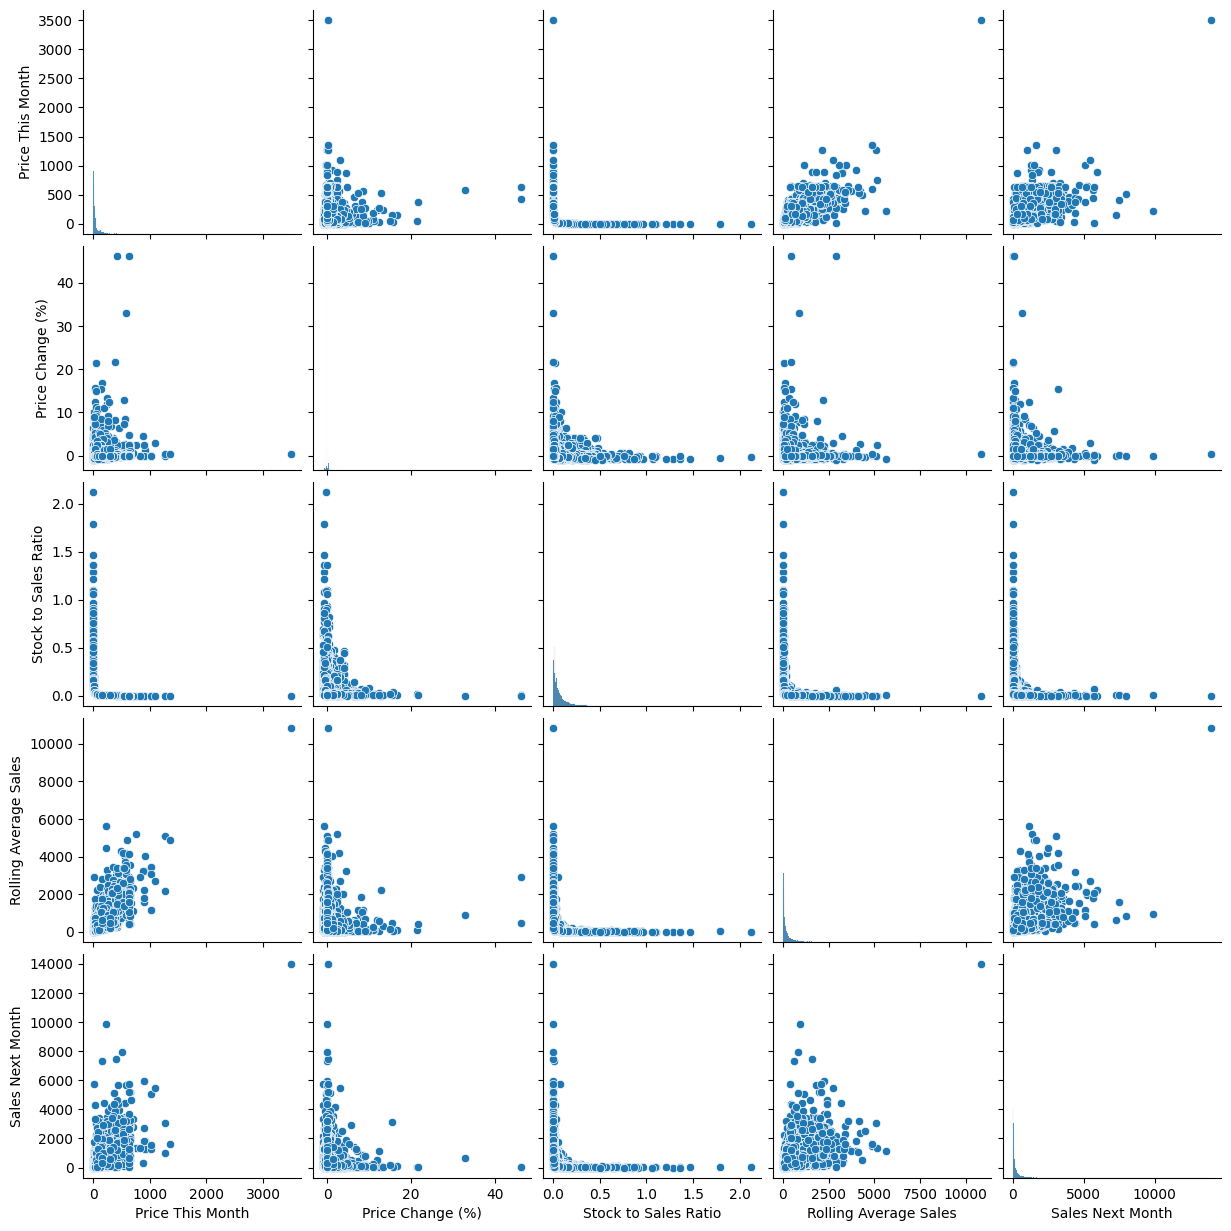

In [ ]:
# Scatter plot
sns.pairplot(prediction_df_monthly[cols_to_keep_monthly])

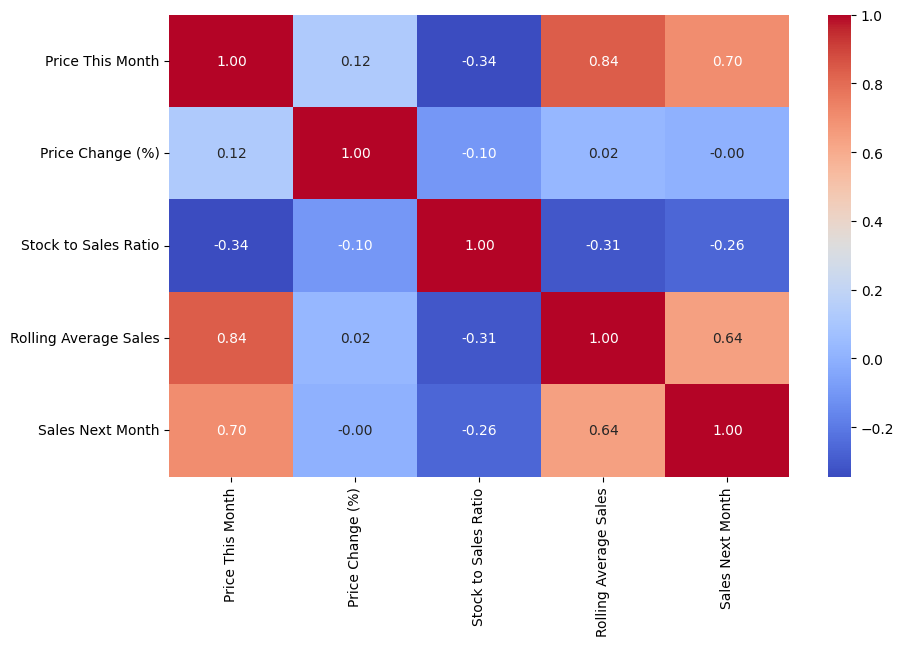

In [ ]:
# Correlation Heatmap
plt.figure(figsize=(10,6))
sns.heatmap(prediction_df_monthly[cols_to_keep_monthly].corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.show()

###### Model Training and Evaluation

In [ ]:
monthly_X = prediction_df_monthly[cols_to_keep_monthly].drop(columns={'Sales Next Month'})
monthly_y = prediction_df_monthly['Sales Next Month']
# prediction_df_monthly['log_sales'] = np.log1p(prediction_df_monthly['Sales Next Month'])
# monthly_y = prediction_df_monthly['log_sales']

In [ ]:
monthly_X

,Price This Month,Price Change (%),Stock to Sales Ratio,Rolling Average Sales
0,15.894,-7.000000e-01,0.062264,100.662
1,52.980,2.333333e+00,0.018525,74.172
2,52.980,-1.341153e-16,0.018816,185.430
3,24.990,1.500000e+00,0.038476,17.493
4,109.740,0.000000e+00,0.009030,109.740
...,...,...,...,...
14597,253.320,1.500000e+00,0.003942,430.644
14598,160.650,0.000000e+00,0.006215,481.950
14599,160.650,0.000000e+00,0.006215,642.600
14600,300.180,1.500000e+00,0.003320,210.126


In [ ]:
monthly_y

,Sales Next Month
0,52.980
1,317.880
2,137.748
3,24.990
4,219.480
...,...
14597,253.320
14598,642.600
14599,321.300
14600,600.360


**Data Splitting:** The dataset is divided into training, validation, and test sets to ensure robust model evaluation and hyperparameter tuning.

In [ ]:
monthly_X_train, monthly_X_temp, monthly_y_train, monthly_y_temp = train_test_split(monthly_X, monthly_y, test_size=0.2, random_state=42)

monthly_X_val, monthly_X_test, monthly_y_val, monthly_y_test = train_test_split(monthly_X_temp, monthly_y_temp, test_size=0.5, random_state=42)


**Hyperparameter Optimization and Model Training:** Optuna is utilized to find the optimal hyperparameters for the XGBoost Regressor.

In [ ]:
# Create an Optuna study
study = optuna.create_study(direction='maximize')

# Optimize the objective function
study.optimize(lambda trial: objective(trial, monthly_X_train, monthly_y_train, monthly_X_val, monthly_y_val), n_trials=50)

# Print the best hyperparameters and performance
print(f"Best hyperparameters: {study.best_params}")
print(f"Best MSE: {study.best_value}")


[I 2025-04-09 16:01:14,022] A new study created in memory with name: no-name-4a7348bb-c9e1-4061-a87b-07602b9ccb56
<ipython-input-135-caa56a9480ba>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
[I 2025-04-09 16:01:15,177] Trial 0 finished with value: 0.5051594156741306 and parameters: {'learning_rate': 0.004893182581422567, 'max_depth': 3, 'n_estimators': 921}. Best is trial 0 with value: 0.5051594156741306.
<ipython-input-135-caa56a9480ba>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
[I 2025-04-09 16:01:17,569] Trial 1 finish

Best hyperparameters: {'learning_rate': 0.017815106324144566, 'max_depth': 3, 'n_estimators': 147}
Best MSE: 0.5076607790189316


<Figure size 1200x800 with 0 Axes>

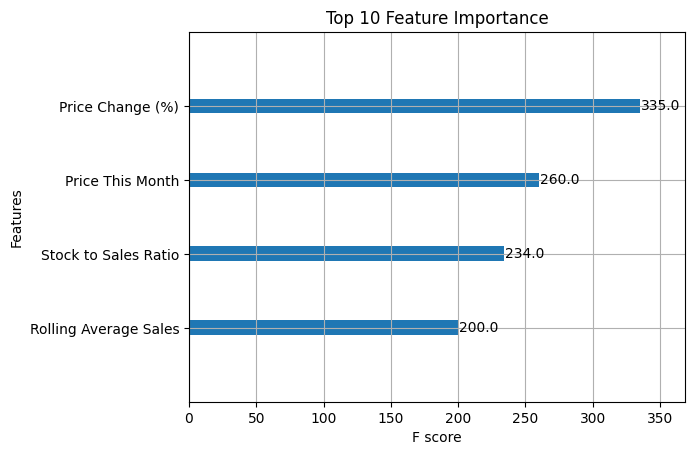

MAE: 125.55
MSE: 60549.56
R² Score: 0.51


In [ ]:
# Use the best hyperparameters from Optuna
hyperparams = study.best_params

xgb_monthly = XGBRegressor(
    n_estimators=hyperparams['n_estimators'],
    learning_rate=hyperparams['learning_rate'],
    max_depth=hyperparams['max_depth'],
    random_state=42
)

# Train the final model
xgb_monthly.fit(monthly_X_train, monthly_y_train)

importance = xgb_monthly.get_booster().get_score(importance_type='weight')

# Visualize the feature importance
plt.figure(figsize=(12, 8))
xgboost.plot_importance(xgb_monthly, importance_type='weight', max_num_features=10)
plt.title('Top 10 Feature Importance')
plt.show()

# Predict and evaluate on the validation set
monthly_y_pred = xgb_monthly.predict(monthly_X_val)


# Calculate metrics
mae = mean_absolute_error(monthly_y_val, monthly_y_pred)
mse = mean_squared_error(monthly_y_val, monthly_y_pred)
r2 = r2_score(monthly_y_val, monthly_y_pred)

# # Predict and evaluate on the validation set
# monthly_y_pred_log = xgb_monthly.predict(monthly_X_val)
# monthly_y_pred_unlog = np.expm1(monthly_y_pred_log)  # Convert log-predictions back to original scale

# monthly_y_val_unlog = np.expm1(monthly_y_val)  # Un-log transform actual values

# # Calculate metrics
# mae = mean_absolute_error(monthly_y_val_unlog, monthly_y_pred_unlog)
# mse = mean_squared_error(monthly_y_val_unlog, monthly_y_pred_unlog)
# r2 = r2_score(monthly_y_val_unlog, monthly_y_pred_unlog)

# Print performance metrics
print(f"MAE: {mae:.2f}")
print(f"MSE: {mse:.2f}")
print(f"R² Score: {r2:.2f}")


##### Quarterly Sales Prediction Model

This section focuses on preparing the data and training the XGBoost model specifically for quarterly sales predictions. Features are engineered to capture quarterly trends, lags, and ratios, designed to provide comprehensive input for the model.

###### Data Aggregation and Lag Feature Engineering

In [ ]:
prediction_df_quarterly = prediction_df.copy().drop(columns=['Year-Week', 'Year-Month'])
prediction_df_quarterly

,Product ID,Order Date,Price,Quantity,Sales,Year-Quarter
0,TEC-AC-10003033,2012-07-31,329.950,7,2309.650,2012-3
1,FUR-CH-10003950,2013-02-05,412.155,9,3709.395,2013-1
2,TEC-PH-10004664,2013-10-17,575.019,9,5175.171,2013-4
3,TEC-PH-10004583,2013-01-28,578.502,5,2892.510,2013-1
4,TEC-SHA-10000501,2013-11-05,354.120,8,2832.960,2013-4
...,...,...,...,...,...,...
51285,OFF-FA-10000746,2014-06-19,13.020,5,65.100,2014-2
51286,OFF-AP-10002906,2014-06-20,0.444,1,0.444,2014-2
51287,OFF-EN-10001219,2013-12-02,7.640,3,22.920,2013-4
51288,OFF-BI-10000806,2012-02-18,6.720,2,13.440,2012-1


In [ ]:
prediction_df_quarterly = prediction_df_quarterly.groupby(['Product ID', 'Year-Quarter']).agg({
    'Price': 'mean',
    'Quantity': 'sum',
    'Sales': 'sum'
}).reset_index()

prediction_df_quarterly

,Product ID,Year-Quarter,Price,Quantity,Sales
0,FUR-ADV-10000002,2014-2,53.040,2,106.080
1,FUR-ADV-10000002,2014-3,53.040,1,53.040
2,FUR-ADV-10000108,2011-2,50.010,2,100.020
3,FUR-ADV-10000108,2012-1,50.010,4,200.040
4,FUR-ADV-10000108,2012-2,50.010,1,50.010
...,...,...,...,...,...
41775,TEC-STA-10004542,2014-3,28.056,15,577.152
41776,TEC-STA-10004542,2014-4,40.080,4,160.320
41777,TEC-STA-10004834,2011-4,43.092,4,172.368
41778,TEC-STA-10004834,2013-3,32.319,1,32.319


In [ ]:
prediction_df_quarterly = prediction_df_quarterly.sort_values(by=['Product ID', 'Year-Quarter'])

# Quantity last quarter
prediction_df_quarterly['Quantity Last Quarter'] = prediction_df_quarterly.groupby('Product ID')['Quantity'].shift(1)
prediction_df_quarterly = prediction_df_quarterly.dropna(subset=['Quantity Last Quarter'])

# Sales last quarter and next quarter
prediction_df_quarterly['Sales Last Quarter'] = prediction_df_quarterly.groupby('Product ID')['Sales'].shift(1)
prediction_df_quarterly = prediction_df_quarterly.dropna(subset=['Sales Last Quarter'])

prediction_df_quarterly['Sales Next Quarter'] = prediction_df_quarterly.groupby('Product ID')['Sales'].shift(-1)
prediction_df_quarterly = prediction_df_quarterly.dropna(subset=['Sales Next Quarter'])

prediction_df_quarterly = prediction_df_quarterly.reset_index(drop=True)

# Rearranging columns
prediction_df_quarterly = prediction_df_quarterly[['Product ID', 'Year-Quarter', 'Price', 'Quantity Last Quarter', 'Sales Last Quarter', 'Quantity', 'Sales', 'Sales Next Quarter']]

# Renaming columns
prediction_df_quarterly.rename(columns={
    'Price': 'Price This Quarter',
    'Sales': 'Sales This Quarter',
    'Quantity': 'Quantity This Quarter'
  }, inplace=True)

In [ ]:
# Price last quarter
prediction_df_quarterly["Price Last Quarter"] = prediction_df_quarterly.groupby("Product ID")["Price This Quarter"].shift(1)
prediction_df_quarterly = prediction_df_quarterly.dropna(subset=['Price Last Quarter'])

# Price change % (change from price last quarter to price this quarter, per unit price last quarter)
prediction_df_quarterly["Price Change (%)"] = (prediction_df_quarterly["Price This Quarter"] - prediction_df_quarterly["Price Last Quarter"]) / prediction_df_quarterly["Price Last Quarter"]
prediction_df_quarterly = prediction_df_quarterly.dropna(subset=['Price Change (%)'])

# Sales growth rate (growth from sales last quarter to sales this quarter, per unit sales last quarter)
prediction_df_quarterly["Sales Growth Rate"] = (prediction_df_quarterly["Sales This Quarter"] - prediction_df_quarterly["Sales Last Quarter"]) / prediction_df_quarterly["Sales Last Quarter"]
prediction_df_quarterly = prediction_df_quarterly.dropna(subset=['Sales Growth Rate'])

# Stock to sales ratio (ratio of quantity this quarter to sales this quarter)
prediction_df_quarterly["Stock to Sales Ratio"] = prediction_df_quarterly["Quantity This Quarter"] / (prediction_df_quarterly["Sales This Quarter"] + 1)
prediction_df_quarterly = prediction_df_quarterly.dropna(subset=['Stock to Sales Ratio'])

# Momentum (sales this quarter - sales last quarter)
prediction_df_quarterly["Momentum"] = prediction_df_quarterly["Sales This Quarter"] - prediction_df_quarterly["Sales Last Quarter"]
prediction_df_quarterly = prediction_df_quarterly.dropna(subset=['Momentum'])

# Rolling average sales (mean of sales this quarter and sales last quarter)
prediction_df_quarterly["Rolling Average Sales"] = prediction_df_quarterly[["Sales Last Quarter", "Sales This Quarter"]].mean(axis=1)
prediction_df_quarterly = prediction_df_quarterly.dropna(subset=['Rolling Average Sales'])

# Price to Sales Ratio
prediction_df_quarterly["Price-to-Sales Ratio"] = prediction_df_quarterly["Price This Quarter"] / (prediction_df_quarterly["Sales This Quarter"] + 1)
prediction_df_quarterly = prediction_df_quarterly.dropna(subset=['Price-to-Sales Ratio'])



# # Elasticity ratios
# # First calculating the change % of quantity and sales
# prediction_df_quarterly["Quantity Change (%)"] = (prediction_df_quarterly["Quantity This Quarter"] - prediction_df_quarterly["Quantity Last Quarter"]) / prediction_df_quarterly["Quantity Last Quarter"]
# prediction_df_quarterly = prediction_df_quarterly.dropna(subset=['Quantity Change (%)'])
# prediction_df_quarterly["Sales Change (%)"] = (prediction_df_quarterly["Sales This Quarter"] - prediction_df_quarterly["Sales Last Quarter"]) / prediction_df_quarterly["Sales Last Quarter"]
# prediction_df_quarterly = prediction_df_quarterly.dropna(subset=['Sales Change (%)'])

# # Price-Quantity elasticity
# prediction_df_quarterly["Price-Quantity Elasticity"] = prediction_df_quarterly["Quantity Change (%)"] / (prediction_df_quarterly["Price Change (%)"] + 1)
# prediction_df_quarterly = prediction_df_quarterly.dropna(subset=['Price-Quantity Elasticity'])

# # Price-Sales elasticity
# prediction_df_quarterly["Price-Sales Elasticity"] = prediction_df_quarterly["Sales Change (%)"] / (prediction_df_quarterly["Price Change (%)"] + 1)
# prediction_df_quarterly = prediction_df_quarterly.dropna(subset=['Price-Sales Elasticity'])

# # Price Impact
# prediction_df_quarterly["Price-Impact"] = (prediction_df_quarterly["Price-Sales Elasticity"] + prediction_df_quarterly["Price-Quantity Elasticity"]) / 2
# prediction_df_quarterly = prediction_df_quarterly.dropna(subset=['Price-Impact'])


prediction_df_quarterly = prediction_df_quarterly.reset_index(drop=True)

prediction_df_quarterly

,Product ID,Year-Quarter,Price This Quarter,Quantity Last Quarter,Sales Last Quarter,Quantity This Quarter,Sales This Quarter,Sales Next Quarter,Price Last Quarter,Price Change (%),Sales Growth Rate,Stock to Sales Ratio,Momentum,Rolling Average Sales,Price-to-Sales Ratio
0,FUR-ADV-10000183,2014-1,52.980,6.0,95.364,1,52.980,137.748,15.894,2.333333,-0.444444,0.018525,-42.384,74.172,0.981475
1,FUR-ADV-10000183,2014-3,37.086,1.0,52.980,5,137.748,317.880,52.980,-0.300000,1.600000,0.036037,84.768,95.364,0.267290
2,FUR-ADV-10000188,2014-1,24.990,1.0,9.996,1,24.990,24.990,9.996,1.500000,1.500000,0.038476,14.994,17.493,0.961524
3,FUR-ADV-10000571,2013-3,109.740,1.0,109.740,2,219.480,109.740,109.740,0.000000,1.000000,0.009071,109.740,164.610,0.497732
4,FUR-ADV-10000571,2013-4,109.740,2.0,219.480,1,109.740,877.920,109.740,0.000000,-0.500000,0.009030,-109.740,164.610,0.990970
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9672,TEC-STA-10002650,2014-3,163.500,4.0,196.200,2,327.000,65.400,49.050,2.333333,0.666667,0.006098,130.800,261.600,0.498476
9673,TEC-STA-10003081,2014-1,72.930,1.0,72.930,2,145.860,21.879,72.930,0.000000,1.000000,0.013618,72.930,109.395,0.496595
9674,TEC-STA-10003330,2013-3,253.320,1.0,101.328,3,759.960,1519.920,101.328,1.500000,6.500000,0.003942,658.632,430.644,0.332895
9675,TEC-STA-10003330,2013-4,253.320,3.0,759.960,6,1519.920,253.320,253.320,0.000000,1.000000,0.003945,759.960,1139.940,0.166557


In [ ]:
prediction_df_quarterly.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9677 entries, 0 to 9676
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Product ID             9677 non-null   object 
 1   Year-Quarter           9677 non-null   object 
 2   Price This Quarter     9677 non-null   float64
 3   Quantity Last Quarter  9677 non-null   float64
 4   Sales Last Quarter     9677 non-null   float64
 5   Quantity This Quarter  9677 non-null   int64  
 6   Sales This Quarter     9677 non-null   float64
 7   Sales Next Quarter     9677 non-null   float64
 8   Price Last Quarter     9677 non-null   float64
 9   Price Change (%)       9677 non-null   float64
 10  Sales Growth Rate      9677 non-null   float64
 11  Stock to Sales Ratio   9677 non-null   float64
 12  Momentum               9677 non-null   float64
 13  Rolling Average Sales  9677 non-null   float64
 14  Price-to-Sales Ratio   9677 non-null   float64
dtypes: f

###### Exploratory Data Analysis (EDA)

Prior to model training, an Exploratory Data Analysis (EDA) is performed on the prepared quarterly dataset. This involves visualizing feature relationships through pair plots and quantifying correlations using a heatmap to understand the dataset's structure and identify potential relationships between features and the target variable.

In [ ]:
# Dropping weakly-related features
cols_to_keep_quarterly = [
    'Price This Quarter',
    # 'Price Last Quarter',
    # 'Sales This Quarter',
    # 'Sales Last Quarter',
    # 'Quantity This Quarter',
    # 'Quantity Last Quarter',
    'Price Change (%)',
    # 'Sales Growth Rate',
    'Stock to Sales Ratio',
    # 'Momentum',
    'Rolling Average Sales',
    # 'Price-to-Sales Ratio',
    # "Price-Quantity Elasticity",
    # "Price-Sales Elasticity",
    # "Price-Impact",
    'Sales Next Quarter'
  ]

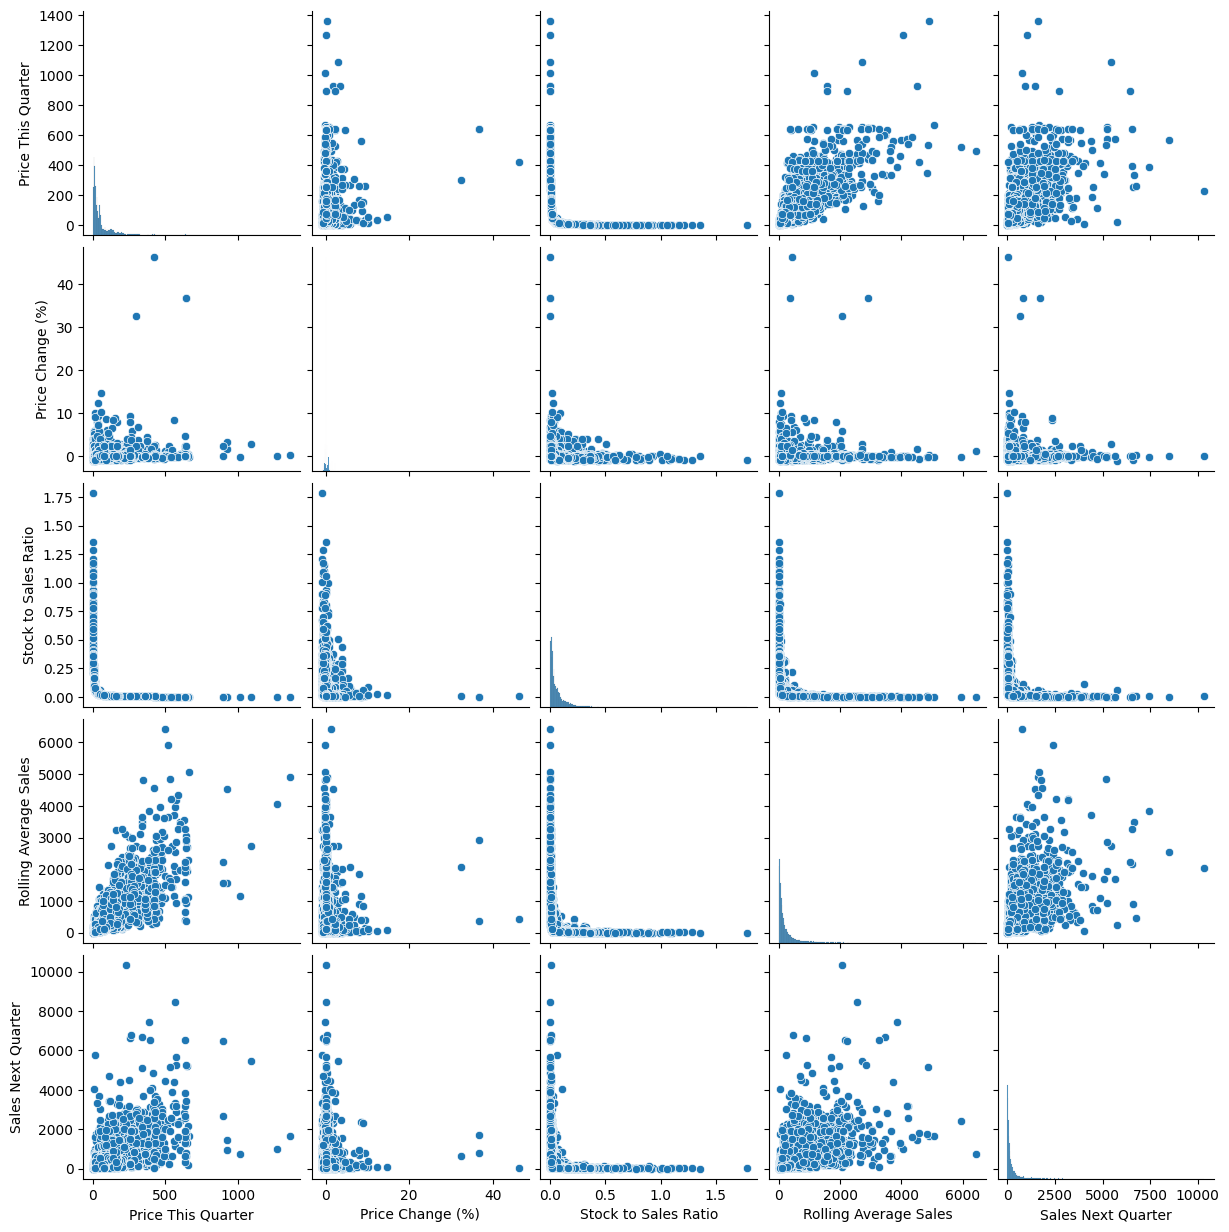

In [ ]:
# Scatter plot
sns.pairplot(prediction_df_quarterly[cols_to_keep_quarterly])

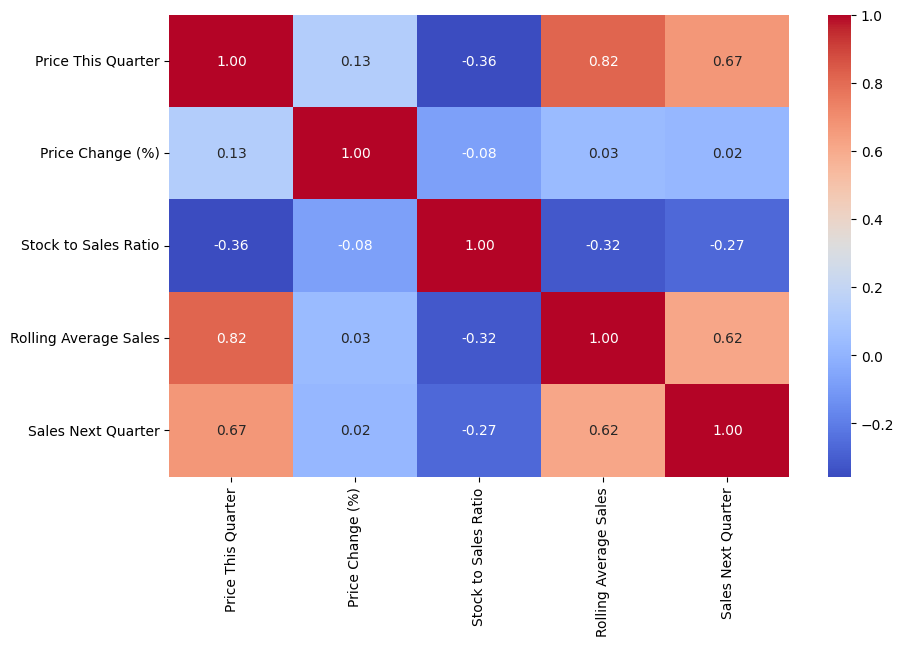

In [ ]:
# Correlation Heatmap
plt.figure(figsize=(10,6))
sns.heatmap(prediction_df_quarterly[cols_to_keep_quarterly].corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.show()

###### Model Training and Evaluation

In [ ]:
quarterly_X = prediction_df_quarterly[cols_to_keep_quarterly].drop(columns={'Sales Next Quarter'})
quarterly_y = prediction_df_quarterly['Sales Next Quarter']
# prediction_df_quarterly['log_sales'] = np.log1p(prediction_df_quarterly['Sales Next Quarter'])
# quarterly_y = prediction_df_quarterly['log_sales']

In [ ]:
quarterly_X

,Price This Quarter,Price Change (%),Stock to Sales Ratio,Rolling Average Sales
0,52.980,2.333333,0.018525,74.172
1,37.086,-0.300000,0.036037,95.364
2,24.990,1.500000,0.038476,17.493
3,109.740,0.000000,0.009071,164.610
4,109.740,0.000000,0.009030,164.610
...,...,...,...,...
9672,163.500,2.333333,0.006098,261.600
9673,72.930,0.000000,0.013618,109.395
9674,253.320,1.500000,0.003942,430.644
9675,253.320,0.000000,0.003945,1139.940


In [ ]:
quarterly_y

,Sales Next Quarter
0,137.748
1,317.880
2,24.990
3,109.740
4,877.920
...,...
9672,65.400
9673,21.879
9674,1519.920
9675,253.320


**Data Splitting:** The dataset is divided into training, validation, and test sets to ensure robust model evaluation and hyperparameter tuning.

In [ ]:
quarterly_X_train, quarterly_X_temp, quarterly_y_train, quarterly_y_temp = train_test_split(quarterly_X, quarterly_y, test_size=0.2, random_state=42)

quarterly_X_val, quarterly_X_test, quarterly_y_val, quarterly_y_test = train_test_split(quarterly_X_temp, quarterly_y_temp, test_size=0.5, random_state=42)


**Hyperparameter Optimization and Model Training:** Optuna is utilized to find the optimal hyperparameters for the XGBoost Regressor.

In [ ]:
# Create an Optuna study
study = optuna.create_study(direction='maximize')

# Optimize the objective function
study.optimize(lambda trial: objective(trial, quarterly_X_train, quarterly_y_train, quarterly_X_val, quarterly_y_val), n_trials=50)

# Print the best hyperparameters and performance
print(f"Best hyperparameters: {study.best_params}")
print(f"Best MSE: {study.best_value}")


[I 2025-04-09 16:01:59,434] A new study created in memory with name: no-name-873248f3-77de-470c-b3bb-e2b31afeb7f2
<ipython-input-135-caa56a9480ba>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
[I 2025-04-09 16:02:03,402] Trial 0 finished with value: 0.4161599152033816 and parameters: {'learning_rate': 0.00788685768606791, 'max_depth': 10, 'n_estimators': 747}. Best is trial 0 with value: 0.4161599152033816.
<ipython-input-135-caa56a9480ba>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
[I 2025-04-09 16:02:06,114] Trial 1 finish

Best hyperparameters: {'learning_rate': 0.03859328361384066, 'max_depth': 4, 'n_estimators': 153}
Best MSE: 0.5903474677037632


<Figure size 1200x800 with 0 Axes>

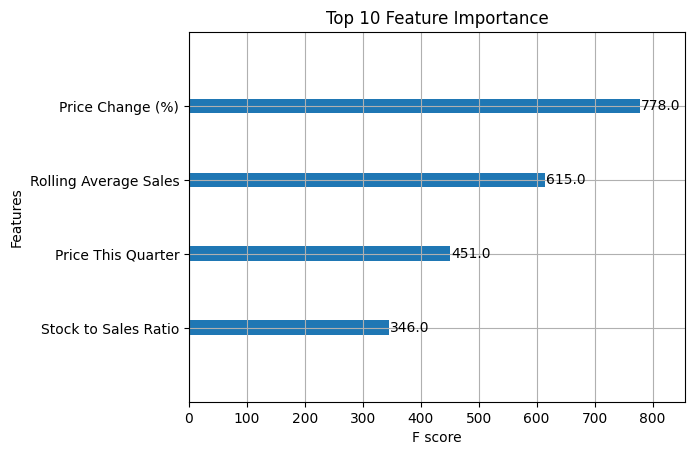

MAE: 148.57
MSE: 95415.58
R² Score: 0.59


In [ ]:
# Use the best hyperparameters from Optuna
hyperparams = study.best_params

xgb_quarterly = XGBRegressor(
    n_estimators=hyperparams['n_estimators'],
    learning_rate=hyperparams['learning_rate'],
    max_depth=hyperparams['max_depth'],
    random_state=42
)

# Train the final model
xgb_quarterly.fit(quarterly_X_train, quarterly_y_train)

importance = xgb_quarterly.get_booster().get_score(importance_type='weight')

# Visualize the feature importance
plt.figure(figsize=(12, 8))
xgboost.plot_importance(xgb_quarterly, importance_type='weight', max_num_features=10)
plt.title('Top 10 Feature Importance')
plt.show()

# Predict and evaluate on the validation set
quarterly_y_pred = xgb_quarterly.predict(quarterly_X_val)


# Calculate metrics
mae = mean_absolute_error(quarterly_y_val, quarterly_y_pred)
mse = mean_squared_error(quarterly_y_val, quarterly_y_pred)
r2 = r2_score(quarterly_y_val, quarterly_y_pred)

# # Predict and evaluate on the validation set
# quarterly_y_pred_log = xgb_quarterly.predict(quarterly_X_val)
# quarterly_y_pred_unlog = np.expm1(quarterly_y_pred_log)  # Convert log-predictions back to original scale

# quarterly_y_val_unlog = np.expm1(quarterly_y_val)  # Un-log transform actual values

# # Calculate metrics
# mae = mean_absolute_error(quarterly_y_val_unlog, quarterly_y_pred_unlog)
# mse = mean_squared_error(quarterly_y_val_unlog, quarterly_y_pred_unlog)
# r2 = r2_score(quarterly_y_val_unlog, quarterly_y_pred_unlog)

# Print performance metrics
print(f"MAE: {mae:.2f}")
print(f"MSE: {mse:.2f}")
print(f"R² Score: {r2:.2f}")


## Model Saving

After training, the final XGBoost models (weekly, monthly, and quarterly) are saved to disk using **joblib**. This allows them to be easily loaded and reused in the backend or for future predictions without needing to retrain them.

In [ ]:
models = [xgb_weekly, xgb_monthly, xgb_quarterly]

In [ ]:
import os
os.makedirs("ml_modelss", exist_ok=True)

from joblib import dump

In [ ]:
dump(xgb_weekly, f'ml_modelss/xgboost_weekly.joblib')
dump(xgb_monthly, f'ml_modelss/xgboost_monthly.joblib')
dump(xgb_quarterly, f'ml_modelss/xgboost_quarterly.joblib')

['ml_modelss/xgboost_quarterly.joblib']